# Simulation_CLP_PID_FF


In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

from importlib import reload

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
package_LAB = reload(package_LAB)
from package_LAB import LL_RT, PID_RT, IMC, OLP_FF, OLP_NOFF, CLP_FF, CLP_NOFF, CLP_FF_FOLLOW

## Simulation Parameters

In [194]:
mode = CLP_NOFF

ManFF = False

alpha = 0.1
MVMin = 0
MVMax = 100

## Values from experiment + optimization

In [195]:
K_SOPDT_OPT = 0.3562231735602847
T1_SOPDT_OPT = 164.90136281744202
T2_SOPDT_OPT = 41.937854162157095
theta_SOPDT_OPT = 1.058634883965729

K_SOPDT_OPT_DV = 0.3470577806298568
T1_SOPDT_OPT_DV = 160.56027097048144
T2_SOPDT_OPT_DV = 35.99302014643125
theta_SOPDT_OPT_DV = 9.177287203018302

## Feed-forward time constants & dead-time

In [196]:
K_FF = -K_SOPDT_OPT_DV/K_SOPDT_OPT
print(K_FF)
thetaFF = max([0, theta_SOPDT_OPT_DV - theta_SOPDT_OPT])

TLEAD_LL1 = T1_SOPDT_OPT
TLAG_LL1 = T1_SOPDT_OPT_DV

TLEAD_LL2 = T2_SOPDT_OPT
TLAG_LL2 = T2_SOPDT_OPT_DV


-0.9742706437685564


## Calculate IMC Values


In [197]:
gammas = [0.55, 0.2 , 0.9]

Kcs = []
Tis = []
Tds = []

for gamma in gammas:
    Kc, Ti, Td = IMC(K_SOPDT_OPT, T1_SOPDT_OPT, T2_SOPDT_OPT, theta_SOPDT_OPT, gamma)
    Kcs.append(Kc)
    Tis.append(Ti)
    Tds.append(Td)

## Process Simulation

In [198]:
MV0 = 50
DV0 = 50

PV0 = 49.4

(0.0, 1750.0)

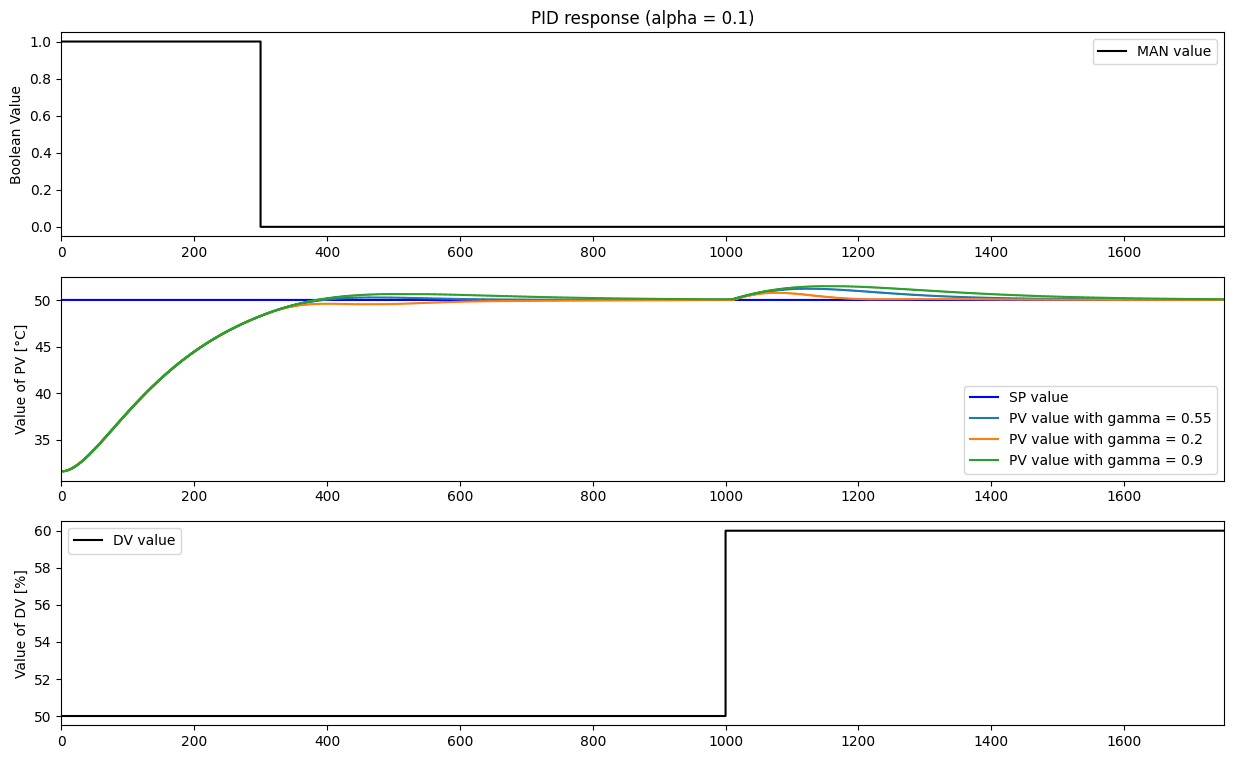

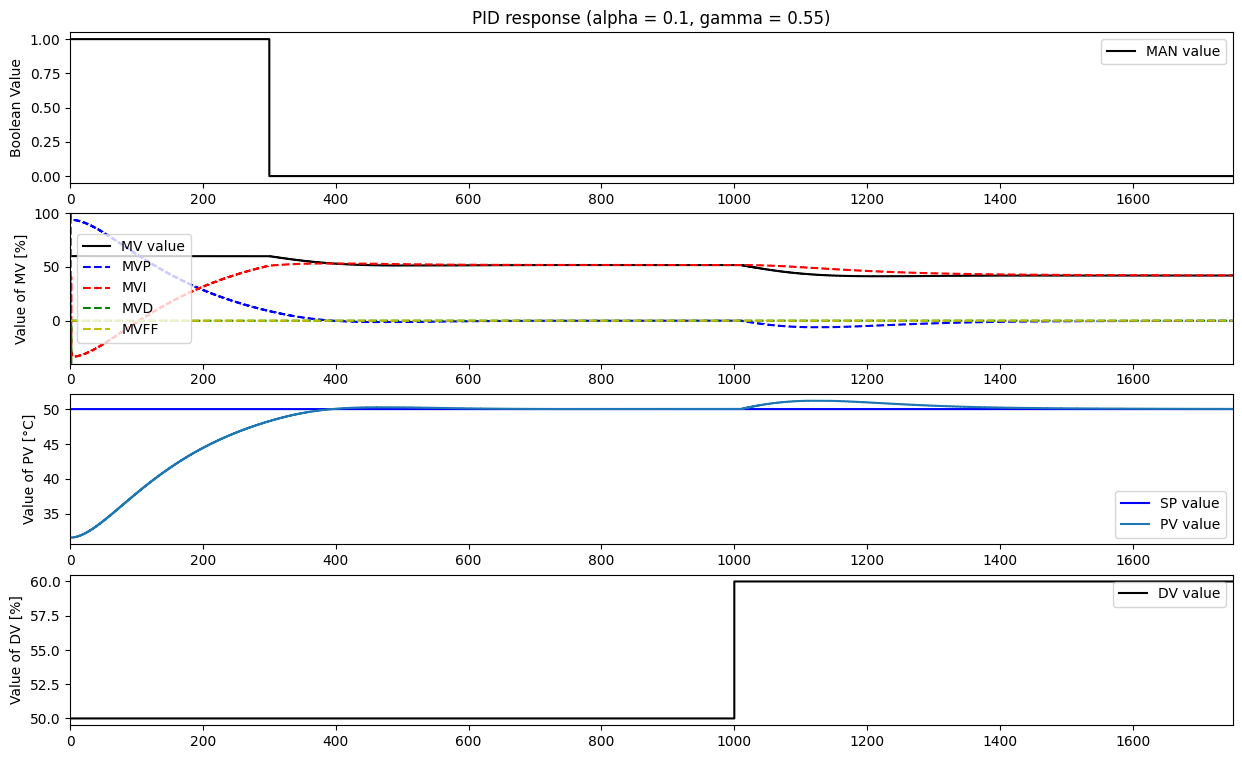

In [199]:
TSim = 1750
Ts = 1
N = int(TSim/Ts) + 1
Treach = 300 #Time to reach first setpoint

# Path for variables
if mode == CLP_FF:
    UseFF = False
    ManPath = {0: True, Treach: False, TSim : False}
    MVManPath = {0:60, TSim:60}
    SPPath = {0: 50, TSim : 50}
    DVPath = {0: 50, 1000: 60, TSim : 60}
elif mode == CLP_FF_FOLLOW:
    UseFF = False
    ManPath = {0: True, Treach: False, TSim : False}
    MVManPath = {0:60, TSim:60}
    SPPath = {0: 50, 425: 55, 1000: 45, TSim : 45}
    DVPath = {0: 50, TSim : 50}
elif mode == CLP_NOFF:
    UseFF = False
    ManPath = {0: True, Treach: False, TSim : False}
    MVManPath = {0:60, TSim:60}
    SPPath = {0: 50, TSim : 50}
    DVPath = {0: 50, 1000: 60, TSim : 60}
elif mode == OLP_FF:
    UseFF = True
    ManPath = {0: True, TSim : True}
    MVManPath = {0:60, TSim:60}
    SPPath = {0: 50, TSim : 50}
    DVPath = {0: 50, 1000: 60, TSim : 60}
    ManFF = True
elif mode == OLP_NOFF:
    UseFF = False
    ManPath = {0: True, TSim : True}
    SPPath = {0: 50, TSim : 50}
    MVManPath = {0:60, TSim:60}
    DVPath = {0: 50, 1000: 60, TSim : 60}


def compute(gamma_index):
    

    t = []
    DV = []
    SP = []
    PV = []

    MVFF_Delay = []
    MVFF_LL1 = []

    MV = []
    MVP = []
    MVI = []
    MVD = []

    MV_Delay_Process = []
    PV_1_Process = []
    PV_Process = []

    MV_Delay_Disturb = []
    PV_1_Disturb = []
    PV_Disturb = []

    Man = []
    MVMan = []
    MVFF = []
    E = []


    for i in range(0,N):
        t.append(i*Ts)
        SelectPath_RT(DVPath, t, DV)
        SelectPath_RT(SPPath,t,SP)
        SelectPath_RT(ManPath,t,Man)
        SelectPath_RT(MVManPath,t,MVMan)
        # Feed-Forward
        Delay_RT(DV-DV0*np.ones_like(DV),thetaFF,Ts,MVFF_Delay,0)

        LL_RT(MVFF_Delay,K_FF,TLEAD_LL1,TLAG_LL1,Ts,MVFF_LL1,0)
        if UseFF:
            LL_RT(MVFF_LL1, 1, TLEAD_LL2, TLAG_LL2, Ts, MVFF, 0)
        else:
            LL_RT(MVFF_LL1, 0, TLEAD_LL2, TLAG_LL2, Ts, MVFF, 0)

    # PID
        PID_RT(SP, PV, Man, MVMan, MVFF, Kcs[gamma_index], Tis[gamma_index], Tds[gamma_index], alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)
        # Process
        # Input-output dynamics P(s)
        Delay_RT(MV,theta_SOPDT_OPT,Ts,MV_Delay_Process,MV0)
        FO_RT(MV_Delay_Process,K_SOPDT_OPT,T1_SOPDT_OPT,Ts,PV_1_Process,0)
        FO_RT(PV_1_Process,1,T2_SOPDT_OPT,Ts,PV_Process,0)

        # Disturb  ce dynamics D(s)
        Delay_RT(DV - DV0*np.ones_like(DV),theta_SOPDT_OPT_DV,Ts,MV_Delay_Disturb,0)
        FO_RT(MV_Delay_Disturb,K_SOPDT_OPT_DV,T1_SOPDT_OPT_DV,Ts,PV_1_Disturb,0)
        FO_RT(PV_1_Disturb,1,T2_SOPDT_OPT_DV,Ts,PV_Disturb,0)
        PV.append(PV_Process[-1] + PV_1_Disturb[-1] + PV0-K_SOPDT_OPT*MV0)
    return t, Man, MV, MVP, MVI, MVD, MVFF, PV, DV, SP

plt.figure(figsize = (15,9))
for i in range(len(gammas)):
    t, Man, MV, MVP, MVI, MVD, MVFF, PV, DV, SP = compute(i)
    plt.subplot(3,1,1)
    plt.step(t,Man,'black',label='MAN value',where='post') if i == 0 else None
    plt.ylabel('Boolean Value')
    plt.title(f'PID response (alpha = {alpha})')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

    plt.subplot(3,1,2)
    plt.step(t,SP,'blue',label='SP value',where='post') if i == 0 else None
    plt.step(t,PV,label=f'PV value with gamma = {gammas[i]}',where='post')
    plt.ylabel('Value of PV [°C]')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

    plt.subplot(3,1,3)
    plt.step(t, DV, 'black', label='DV value', where='post') if i == 0 else None
    plt.ylabel('Value of DV [%]')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

t, Man, MV, MVP, MVI, MVD, MVFF, PV, DV, SP = compute(0)
plt.figure(figsize = (15,9))
plt.subplot(4,1,1)
plt.step(t,Man,'black',label='MAN value',where='post')
plt.ylabel('Boolean Value')
plt.title(f'PID response (alpha = {alpha}, gamma = {gammas[0]})')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,MV,'black',label=f'MV value',where='post')
plt.step(t, MVP, 'b--', label=f'MVP', where='post')
plt.step(t, MVI, 'r--', label=f'MVI', where='post')
plt.step(t, MVD, 'g--', label=f'MVD', where='post')
plt.step(t, MVFF, 'y--', label=f'MVFF', where='post')
plt.ylabel('Value of MV [%]')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.ylim([-40, 100])

plt.subplot(4,1,3)
plt.step(t,SP,'blue',label='SP value',where='post')
plt.step(t,PV,label=f'PV value',where='post')
plt.ylabel('Value of PV [°C]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,4)
plt.step(t, DV, 'black', label='DV value', where='post')
plt.ylabel('Value of DV [%]')
plt.legend(loc='best')
plt.xlim([0, TSim])
